# Image similarity search on Azure Cosmos DB for PostgreSQL using the pgvector extension and HNSW index

In this notebook, we explore vector similarty search using the HNSW index of the pgvector extension on Azure Cosmos DB for PostgreSQL.

Before you start:

1. Create an Azure Cosmos DB for PostgreSQL cluster and enable the `pgvector` extension.
2. Create an Azure Blob Storage container to store the images.
3. Run the `data_preprocessing.ipynb` notebook to clean up the SemArt Dataset and the `generate_embeddings.py` script to compute the embeddings of all the images. The embeddings are saved in the `dataset_embeddings.csv` file in the *dataset* folder.
4. Run the `upload_images_to_blob.py` script to upload the images in your Blob Storage container.
5. Run the `upload_data_to_postgresql_hnsw.py` script to create a PostgreSQL table, populate it with data, and create an HNSW index.

## Import libraries

In [ ]:
import os
import math
import psycopg2
import psycopg2.pool
from dotenv import load_dotenv
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from azure.storage.blob import ContainerClient

import constants as c
from utils import (
    vectorize_image_with_filepath,
    vectorize_text,
    display_image_grid,
    download_blob,
)

## Load environment variables

In [2]:
load_dotenv("../.env")

# Azure Cosmos DB for PostgreSQL
postgres_host = os.getenv("POSTGRES_HOST")
postgres_database_name = os.getenv("POSTGRES_DB_NAME")
postgres_user = os.getenv("POSTGRES_USER")
postgres_password = os.getenv("POSTGRES_PASSWORD")
sslmode = "require"
table_name = os.getenv("POSTGRES_TABLE_HNSW_NAME")

# Azure AI Vision
vision_endpoint = os.getenv("VISION_ENDPOINT") + "computervision/"
vision_key = os.getenv("VISION_KEY")
vision_api_version = os.getenv("VISION_VERSION")

# Azure Blob Storage credentials
blob_account_name = os.getenv("BLOB_ACCOUNT_NAME")
blob_account_key = os.getenv("BLOB_ACCOUNT_KEY")
blob_endpoint_suffix = os.getenv("BLOB_ENDPOINT_SUFFIX")
blob_connection_string = (
    f"DefaultEndpointsProtocol=https;AccountName={blob_account_name};"
    f"AccountKey={blob_account_key};EndpointSuffix={blob_endpoint_suffix}"
)
container_name = os.getenv("CONTAINER_NAME")

## Create an Azure Blob Storage container client

Create an Azure Blob Storage `ContainerClient` object to download images from your container. Alternatively, you can display the images using their public URL.

In [3]:
blob_container_client = ContainerClient.from_connection_string(
    conn_str=blob_connection_string,
    container_name=container_name,
)

## Connect to Azure Cosmos DB for PostgreSQL

The following code forms a connection string using the environment variables for your Azure Cosmos DB for PostgreSQL cluster and creates a connection pool to your Postgres database. After that, a `cursor` object is created, which can be used to execute SQL queries with the `execute()` method.

In [4]:
# Build a connection string from the variables
postgres_connection_string = (
    f"host={postgres_host} user={postgres_user} dbname={postgres_database_name} "
    f"password={postgres_password} sslmode={sslmode}"
)

In [5]:
postgresql_pool = psycopg2.pool.SimpleConnectionPool(1, 20, postgres_connection_string)
if postgresql_pool:
    print("Connection pool created successfully")

Connection pool created successfully


In [6]:
# Get a connection from the connection pool
conn = postgresql_pool.getconn()
cursor = conn.cursor()

### Select the first 10 rows of the table to see the data

In [7]:
cursor.execute(f"SELECT COUNT(*) FROM {table_name};")
number_of_records = cursor.fetchone()[0]
print(f"Number of records in the table: {number_of_records}")

Number of records in the table: 11206


In [8]:
cursor.execute(f"SELECT * FROM {table_name} LIMIT 10;")
rows = cursor.fetchall()

df_rows = pd.DataFrame(rows, columns=c.COLUMN_NAMES_LIST)
df_rows.head(10)

image_file                                        description  \
0   19873-1darmst.jpg  The Meyer or Darmstadt Madonna is the last, mo...   
1  18759-guard301.jpg  Whereas Canaletto incorporates classically ins...   
2   00930-30coron.jpg  Fra Angelico dedicated several of his works to...   
3  18424-2105grec.jpg  This portrait is an example of El Greco's late...   
4  21949-4lastsu3.jpg  Leonardo's painting of the Last Supper was con...   
5   39738-04organ.jpg  This is another original version of the Venus ...   
6  29467-canal_mo.jpg  Aert Van der Neer painted his first moonlit la...   
7  12035-painstud.jpg  It is assumed that the painter represented in ...   
8  36091-4absalo1.jpg  The large scene on the long wall opposite to t...   
9   20109-44hooch.jpg  Pieter de Hooch depicts for us incidents in th...   

                      author                              title  \
0  HOLBEIN, Hans the Younger                  Darmstadt Madonna   
1          GUARDI, Francesco  Landscape with a Fisherman's Tent   
2              ANGELICO, Fra       The Coronation of the Virgin   
3                  GRECO, El        Portrait of Cardinal Tavera   
4          LEONARDO da Vinci                    The Last Supper   
5           TIZIANO Vecellio   Venus and Cupid with an Organist   
6         NEER, Aert van der               A Canal by Moonlight   
7                DOU, Gerrit              Painter in his Studio   
8     SALVIATI, Cecchino del      The Story of David (4 scenes)   
9           HOOCH, Pieter de             Woman Reading a Letter   

          technique          type  timeframe  \
0   Oil on limewood     religious  1501-1550   
1     Oil on canvas     landscape  1751-1800   
2   Tempera on wood     religious  1401-1450   
3     Oil on canvas      portrait  1551-1600   
4   Mixed technique     religious  1451-1500   
5     Oil on canvas  mythological  1501-1550   
6  Oil on oak panel     landscape  1601-1650   
7        Oil on oak         genre  1651-1700   
8            Fresco     religious  1501-1550   
9     Oil on canvas         genre  1651-1700   

                                              vector  
0  [-6.2070312,-3.2949219,1.4003906,-1.0898438,-4...  
1  [0.6772461,-1.0214844,0.3095703,-1.9599609,-1....  
2  [-3.53125,-0.46362305,0.6982422,-0.9916992,-2....  
3  [-1.2724609,-0.2644043,-0.8095703,-3.0449219,-...  
4  [-1.3525391,1.9355469,0.47802734,-3.25,-2.5175...  
5  [-4.015625,-2.3242188,1.5888672,-6.1679688,-3....  
6  [2.2011719,-0.20983887,1.4208984,-1.3222656,-3...  
7  [0.5541992,-0.24475098,-0.5957031,-1.1962891,-...  
8  [-4.46875,-4.375,-1.1943359,-2.8574219,-0.2359...  
9  [-1.8203125,1.9199219,2.1484375,-0.9355469,-5....

## Search images using an image or a text prompt

After populating the table with vector data and creating an HNSW index, you can use this image collection to search for images that are most similar to a reference image or a text prompt. The workflow is summarized as follows:

1. Use the Vectorize Image API or the Vectorize Text API to generate vector embeddings of an image or text, respectively.
2. To calculate similarity and retrieve images, use `SELECT` statements and the built-it vector operators of the PostgreSQL database.
3. Display the retrieved images using the `display_image_grid()` function.

**Notes**:

* When making queries, we have the option to specify the size of the dynamic candidate list for search (`ef_search`). In this example, we will use the default value (`40`).
* We will use the same text prompts and reference images as in the [Exact Nearest Neighbors search example](image_search.ipynb), allowing for a comparison of the accuracy of the results.

In [9]:
TOP_N = 12

Specify the number of probes to use during queries and enforce the utilization of the IVFFlat index

In [10]:
cursor.execute("SET hnsw.ef_search = 40;")

### Text-to-Image Search

#### Calculate the vector embedding of the text prompt

Let's search for paintings depicting "a table with flowers."

In [11]:
text_prompt = "a table with flowers"
query_vector = vectorize_text(
    text=text_prompt,
    endpoint=vision_endpoint,
    key=vision_key,
    version=vision_api_version,
)

#### Query the table to find the most similar images

In [12]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} ORDER BY {c.VECTOR_COLUMN_NAME} <=> %s LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME]
)
df_rows.head(TOP_N)

image_file                   author  \
0    08537-2still2.jpg            CEZANNE, Paul   
1    14903-early05.jpg            GAUGUIN, Paul   
2   11309-411delac.jpg        DELACROIX, Eugene   
3    08536-2still1.jpg            CEZANNE, Paul   
4   14993-tahiti52.jpg            GAUGUIN, Paul   
5    14909-early11.jpg            GAUGUIN, Paul   
6   17036-flower09.jpg        GOGH, Vincent van   
7   07635-89d_stil.jpg               CARAVAGGIO   
8   06614-bouquet1.jpg  BRUEGHEL, Jan the Elder   
9   17114-3arles28.jpg        GOGH, Vincent van   
10    19433-flower.jpg    HEEM, Jan Davidsz. de   
11  26109-30young1.jpg            MEMLING, Hans   

                                        title  
0           Still-Life with Flowers and Fruit  
1   Interior of the Artist's Home, Rue Carcel  
2              A Vase of Flowers on a Console  
3                               The Blue Vase  
4                           A Vase of Flowers  
5                   Still-Life with Mandoline  
6                                  Still-Life  
7           Still-Life with Flowers and Fruit  
8                          Bouquet of Flowers  
9         Still-Life with Oleanders and Books  
10  Flower Still-life with Crucifix and Skull  
11                          Flower Still-life

Display the retrieved images.

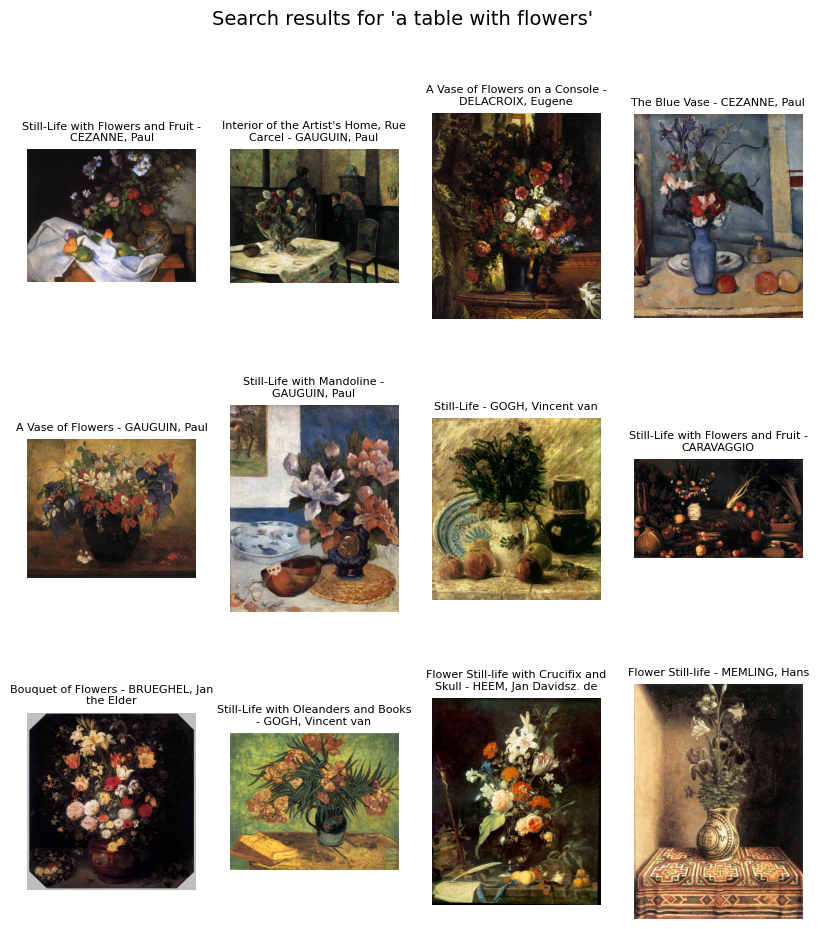

In [13]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]}" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title=f"Search results for '{text_prompt}'",
    nrows=nrows,
    ncols=ncols,
    container_client=blob_container_client,
)

We observe that using the HNSW indexing algorithm, we retrieved all the paintings obtained with exact search.

#### Metadata Filtering

As discussed in the [Exact Nearest Neighbor Search example](image_search.ipynb), implementing accurate and fast metadata filtering in vector search systems is a challenging task. You can read the article [The Missing WHERE Clause in Vector Search](https://www.pinecone.io/learn/vector-search-filtering/) on the Pinecone blog to learn about the two fundamental approaches for metadata filtering and understand the complexities involved in implementing such filters into vector search applications.

When a `WHERE` clause is used alongside an HNSW index, the search process involves performing an approximate nearest neighbor search initially, followed by the application of the `WHERE` clause filter to the results. However, the *post-filtering* approach does **not** guarantee that the desired number of results will be returned.

You can find more information about filtering with the *pgvector* extension on the [pgvector GitHub repository](https://github.com/pgvector/pgvector?tab=readme-ov-file#filtering). You can check out the issue [Understanding HNSW + filtering](https://github.com/pgvector/pgvector/issues/259).

In [14]:
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} "
    f"WHERE {c.AUTHOR_COLUMN_NAME} = 'GOGH, Vincent van' "
    f"ORDER BY {c.VECTOR_COLUMN_NAME} <=> %s "
    f"LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME]
)
df_rows.head(TOP_N)

image_file             author                                title
0  17036-flower09.jpg  GOGH, Vincent van                           Still-Life
1  17114-3arles28.jpg  GOGH, Vincent van  Still-Life with Oleanders and Books
2  17028-flower01.jpg  GOGH, Vincent van          Bowl with Peonies and Roses
3  17034-flower07.jpg  GOGH, Vincent van      Bowl with Zinnias and Geraniums

Display the retrieved images.

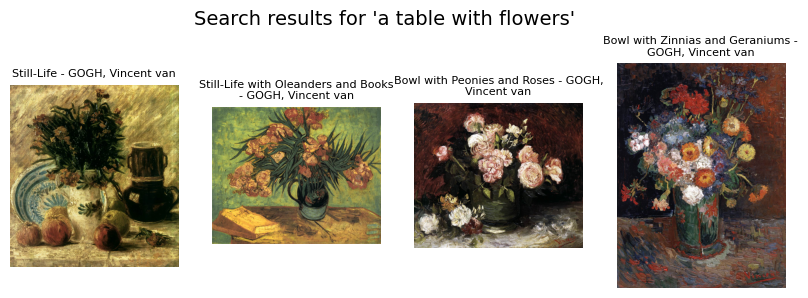

In [15]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]}" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title=f"Search results for '{text_prompt}'",
    nrows=nrows,
    ncols=ncols,
    container_client=blob_container_client,
)

We observe that we were only able to retrieve 4 paintings by Vincent van Gogh. Increasing the value of the `ef_search` parameter may help find more nearest neighbors, but it will also increase the search time.

#### Retrieve paintings by Vincent van Gogh

As we did in the [Exact Nearest Neighbor Search example](image_search.ipynb), let's explore whether it's possible to retrieve paintings of a specific artist without applying filters by including their name in the text prompt.

In [16]:
text_prompt = "flowers by Vincent van Gogh"
query_vector = vectorize_text(
    text=text_prompt,
    endpoint=vision_endpoint,
    key=vision_key,
    version=vision_api_version,
)

In [17]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} ORDER BY {c.VECTOR_COLUMN_NAME} <=> %s LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME]
)
df_rows.head(TOP_N)

image_file             author  \
0   17031-flower04.jpg  GOGH, Vincent van   
1   17114-3arles28.jpg  GOGH, Vincent van   
2   17038-flower11.jpg  GOGH, Vincent van   
3   17033-flower06.jpg  GOGH, Vincent van   
4   17034-flower07.jpg  GOGH, Vincent van   
5   17035-flower08.jpg  GOGH, Vincent van   
6   17030-flower03.jpg  GOGH, Vincent van   
7    17239-6still2.jpg  GOGH, Vincent van   
8   17259-auvers19.jpg  GOGH, Vincent van   
9    17240-6still3.jpg  GOGH, Vincent van   
10  17032-flower05.jpg  GOGH, Vincent van   
11  17171-1asylu04.jpg  GOGH, Vincent van   

                                                title  
0                 Vase with Zinnias and Other Flowers  
1                 Still-Life with Oleanders and Books  
2                      Vase with Daisies and Anemones  
3                            Cineraria in a Flowerpot  
4                     Bowl with Zinnias and Geraniums  
5                       Fritillaries in a Copper Vase  
6              Vase with Carnations and Other Flowers  
7   Still-Life: Vase with Irises against a Yellow ...  
8                         Daubigny's Garden at Auvers  
9                                    Vase with Irises  
10                              Vase with Red Poppies  
11                                           The Iris

Display the retrieved images.

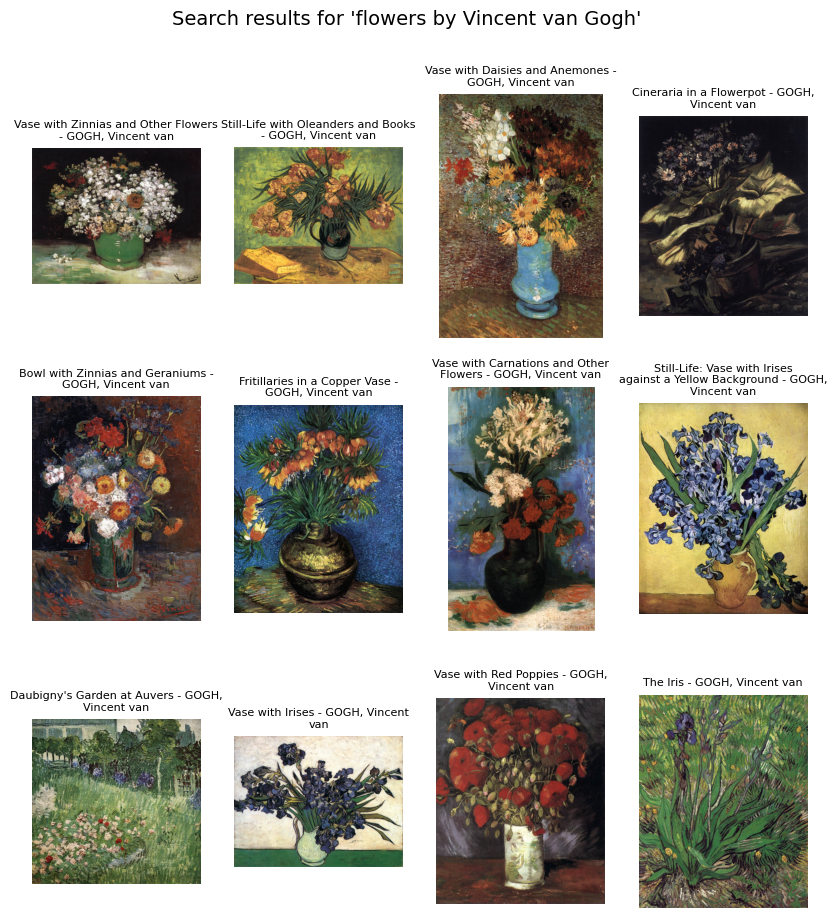

In [18]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]}" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title=f"Search results for '{text_prompt}'",
    nrows=nrows,
    ncols=ncols,
    container_client=blob_container_client,
)

We observe that we retrieve the same paintings as in the exact search.

#### Performance

Using the `EXPLAIN ANALYZE` keywords, we can investigate the execution plan and display the performance of the similarity search query.

In [19]:
# Helper function that displays the query plan (and removes the query vector to imporve readablity)
def print_execution_plan(rows):
    for row in rows:
        print(row[0].replace(str(query_vector).replace(" ", ""), f"[{query_vector[0]}, ..., {query_vector[-1]}]"))

In [20]:
cursor.execute(
    f"EXPLAIN ANALYZE "
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} ORDER BY {c.VECTOR_COLUMN_NAME} <=> %s LIMIT {TOP_N};",
    (str(query_vector),),
)
rows = cursor.fetchall()
print_execution_plan(rows)

Limit  (cost=160.60..163.02 rows=12 width=72) (actual time=1.283..1.406 rows=12 loops=1)
  ->  Index Scan using paintings_hnsw_vector_idx on paintings_hnsw  (cost=160.60..2416.67 rows=11206 width=72) (actual time=1.281..1.403 rows=12 loops=1)
        Order By: (vector <=> '[0.001363333, ..., -0.0010466448]'::vector)
Planning Time: 0.183 ms
Execution Time: 1.439 ms


Let's explore one more example. In the [Exact Nearest Neighbor Search example](image_search.ipynb), we used the following query to retrieve the cosine similarity between the query vector and every vector in our database:

```python
cursor.execute(
    f"EXPLAIN ANALYZE "
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME}, "
    f"1 - ({c.VECTOR_COLUMN_NAME} <=> %s) AS cosine_similarity "
    f"FROM {table_name} ORDER BY cosine_similarity DESC LIMIT {TOP_N};",
    (str(query_vector),),
)
```

Using the `EXPLAIN ANALYZE` keywords, we see that this query does not utilize the HNSW index, which leads to a high execution time. This results from sorting `cosine_similarity` in descending order, as pgvector only supports ascending order index scans.

In [21]:
cursor.execute(
    f"EXPLAIN ANALYZE "
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME}, "
    f"1 - ({c.VECTOR_COLUMN_NAME} <=> %s) AS cosine_similarity "
    f"FROM {table_name} ORDER BY cosine_similarity DESC LIMIT {TOP_N};",
    (str(query_vector),),
)
rows = cursor.fetchall()
print_execution_plan(rows)

Limit  (cost=1482.99..1483.02 rows=12 width=72) (actual time=84.943..84.947 rows=12 loops=1)
  ->  Sort  (cost=1482.99..1511.00 rows=11206 width=72) (actual time=84.941..84.943 rows=12 loops=1)
        Sort Key: (('1'::double precision - (vector <=> '[0.001363333, ..., -0.0010466448]'::vector))) DESC
        Sort Method: top-N heapsort  Memory: 28kB
        ->  Seq Scan on paintings_hnsw  (cost=0.00..1226.09 rows=11206 width=72) (actual time=0.047..81.171 rows=11206 loops=1)
Planning Time: 0.250 ms
Execution Time: 84.994 ms


Let's rewrite the query in order to utilize the HNSW index.

In [22]:
cursor.execute(
    f"EXPLAIN ANALYZE "
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME}, "
    f"{c.VECTOR_COLUMN_NAME} <=> %s AS cosine_distance "
    f"FROM {table_name} ORDER BY cosine_distance LIMIT {TOP_N};",
    (str(query_vector),),
)
rows = cursor.fetchall()
print_execution_plan(rows)

Limit  (cost=160.60..163.02 rows=12 width=72) (actual time=1.887..2.016 rows=12 loops=1)
  ->  Index Scan using paintings_hnsw_vector_idx on paintings_hnsw  (cost=160.60..2416.67 rows=11206 width=72) (actual time=1.886..2.013 rows=12 loops=1)
        Order By: (vector <=> '[0.001363333, ..., -0.0010466448]'::vector)
Planning Time: 0.169 ms
Execution Time: 2.043 ms


### Image-to-Image Search

#### Calculate the vector embeddings of the reference image

We will use the painting [*Still Life with Flowers* by Charles Ginner](https://artuk.org/discover/artworks/still-life-with-flowers-8115/search/actor:ginner-charles-18781952/page/1/view_as/grid).

In [23]:
reference_image = "reference_image.jpg"
query_vector = vectorize_image_with_filepath(
    image_filepath=reference_image,
    endpoint=vision_endpoint,
    key=vision_key,
    version=vision_api_version,
)

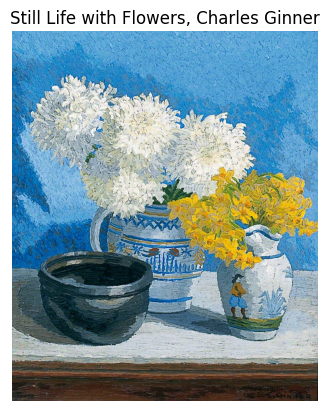

In [24]:
# Display the reference image
plt.imshow(Image.open(reference_image))
plt.axis("off")
plt.title("Still Life with Flowers, Charles Ginner")
plt.show()

#### Query the table to find the most similar images

In [25]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} ORDER BY {c.VECTOR_COLUMN_NAME} <=> %s LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME]
)
df_rows.head(TOP_N)

image_file             author  \
0   17036-flower09.jpg  GOGH, Vincent van   
1    08520-3still1.jpg      CEZANNE, Paul   
2   17034-flower07.jpg  GOGH, Vincent van   
3    14909-early11.jpg      GAUGUIN, Paul   
4   14993-tahiti52.jpg      GAUGUIN, Paul   
5   17037-flower10.jpg  GOGH, Vincent van   
6   17030-flower03.jpg  GOGH, Vincent van   
7   23815-6stilli1.jpg     MANET, Edouard   
8    08536-2still1.jpg      CEZANNE, Paul   
9   17033-flower06.jpg  GOGH, Vincent van   
10  17038-flower11.jpg  GOGH, Vincent van   
11   28609-1north3.jpg      MONET, Claude   

                                     title  
0                               Still-Life  
1        Bouquet of Flowers in a Blue Vase  
2          Bowl with Zinnias and Geraniums  
3                Still-Life with Mandoline  
4                        A Vase of Flowers  
5        Vase with Cornflowers and Poppies  
6   Vase with Carnations and Other Flowers  
7            Vase of Peonies on a Pedestal  
8                            The Blue Vase  
9                 Cineraria in a Flowerpot  
10          Vase with Daisies and Anemones  
11                      Bouquet of Flowers

Display the retrieved images.

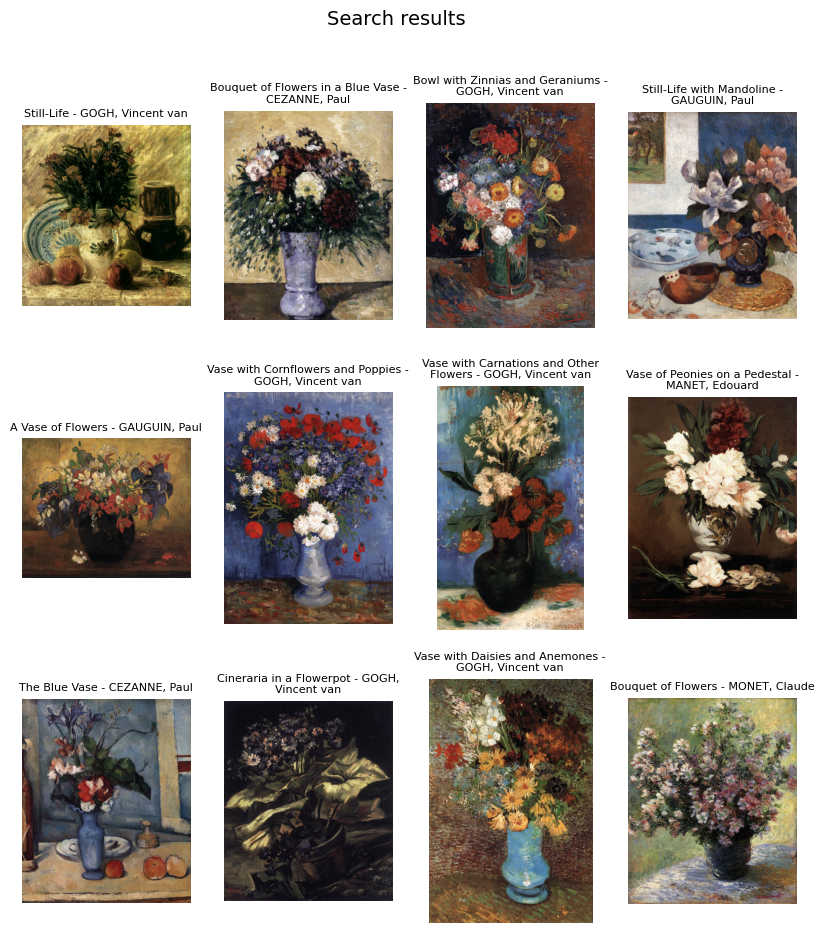

In [26]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]}" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title="Search results",
    nrows=nrows,
    ncols=ncols,
    container_client=blob_container_client,
)

We observe that we were able to retrieve all the paintings obtained with exact search. Additionally, notice that the HNSW index provides more accurate results than the [IVFFlat index](image_search_ivfflat_index.ipynb).

#### Find the most similar images to an image of the dataset

In [27]:
image_file = "00100-stillif.jpg"

# Download the image from Azure Blob Storage
image_stream = download_blob(
    image_filename=image_file,
    container_client=blob_container_client,
)

# Retrieve image metadata
cursor.execute(
    f"SELECT {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} "
    f"WHERE {c.IMAGE_FILE_COLUMN_NAME} = %s;",
    (image_file,),
)
metadata = cursor.fetchone()

# Display the reference image
plt.imshow(Image.open(image_stream))
plt.axis("off")
plt.title(f"{metadata[1]} - {metadata[0]}")
plt.show()

In [28]:
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} "
    f"WHERE {c.IMAGE_FILE_COLUMN_NAME} != %s "
    f"ORDER BY {c.VECTOR_COLUMN_NAME} <=> (SELECT {c.VECTOR_COLUMN_NAME} FROM {table_name} WHERE {c.IMAGE_FILE_COLUMN_NAME} = %s) "
    f"LIMIT {TOP_N};",
    (image_file, image_file),
)

rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME]
)
df_rows.head(TOP_N)

image_file                   author  \
0   19473-vase_flo.jpg    HEEM, Jan Davidsz. de   
1   00095-stilflow.jpg        AELST, Willem van   
2   00107-vasewatc.jpg        AELST, Willem van   
3   19435-flowvase.jpg    HEEM, Jan Davidsz. de   
4   19455-festoon2.jpg    HEEM, Jan Davidsz. de   
5   02782-flowvase.jpg   AST, Balthasar van der   
6   00101-stillife.jpg        AELST, Willem van   
7    36423-bouquet.jpg         SAVERY, Roelandt   
8   06625-flowers9.jpg  BRUEGHEL, Jan the Elder   
9   06620-flowers4.jpg  BRUEGHEL, Jan the Elder   
10   20952-flowers.jpg       KESSEL, Jan van, I   
11  02788-stillif2.jpg   AST, Balthasar van der   

                                        title  
0                             Vase of Flowers  
1                                  Still-Life  
2           Vase of Flowers with Pocket Watch  
3                           Vase with Flowers  
4              Festoon with Flowers and Fruit  
5   Flowers in a Vase with Shells and Insects  
6                           Flower Still-Life  
7                          Bouquet of Flowers  
8   Still-Life of Flowers in a Stoneware Vase  
9                           Flowers in a Vase  
10                                    Flowers  
11                          Flower Still-Life

Display the retrieved images.

In [29]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]}" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title="Search results",
    nrows=nrows,
    ncols=ncols,
    container_client=blob_container_client,
)

We notice that we retrieve the same paintings as in the exact search. Let's investigate the execution plan.

In [30]:
cursor.execute(
    f"EXPLAIN ANALYZE "
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} "
    f"WHERE {c.IMAGE_FILE_COLUMN_NAME} != %s "
    f"ORDER BY {c.VECTOR_COLUMN_NAME} <=> (SELECT {c.VECTOR_COLUMN_NAME} FROM {table_name} WHERE {c.IMAGE_FILE_COLUMN_NAME} = %s) "
    f"LIMIT {TOP_N};",
    (image_file, image_file),
)
rows = cursor.fetchall()
print_execution_plan(rows)

Limit  (cost=164.90..167.35 rows=12 width=72) (actual time=0.808..0.943 rows=12 loops=1)
  InitPlan 1 (returns $0)
    ->  Index Scan using paintings_hnsw_pkey on paintings_hnsw paintings_hnsw_1  (cost=0.29..4.30 rows=1 width=18) (actual time=0.017..0.018 rows=1 loops=1)
          Index Cond: (image_file = '00100-stillif.jpg'::text)
  ->  Index Scan using paintings_hnsw_vector_idx on paintings_hnsw  (cost=160.60..2444.69 rows=11205 width=72) (actual time=0.807..0.940 rows=12 loops=1)
        Order By: (vector <=> $0)
        Filter: (image_file <> '00100-stillif.jpg'::text)
        Rows Removed by Filter: 1
Planning Time: 0.238 ms
Execution Time: 0.981 ms


Let's explore one more example. This time, we will use the painting "Gauguin's Chair" by Vincent van Gogh as a reference.

In [31]:
painting_title = "Gauguin's Chair"
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME} "
    f"FROM {table_name} "
    f"WHERE {c.TITLE_COLUMN_NAME} = %s;",
    (painting_title,),
)
painting_info = cursor.fetchone()
image_file = painting_info[0]

# Download the image from Azure Blob Storage
image_stream = download_blob(
    image_filename=image_file,
    container_client=blob_container_client,
)

# Display the reference image
plt.imshow(Image.open(image_stream))
plt.axis("off")
plt.title(f"{painting_title} - {painting_info[1]}")
plt.show()

In [32]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} "
    f"WHERE {c.IMAGE_FILE_COLUMN_NAME} != %s "
    f"ORDER BY {c.VECTOR_COLUMN_NAME} <=> (SELECT {c.VECTOR_COLUMN_NAME} FROM {table_name} WHERE {c.IMAGE_FILE_COLUMN_NAME} = %s) "
    f"LIMIT {TOP_N};",
    (image_file, image_file),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME]
)
df_rows.head(TOP_N)

image_file             author  \
0    17137-arles59.jpg  GOGH, Vincent van   
1   17230-4earlie1.jpg  GOGH, Vincent van   
2   17114-3arles28.jpg  GOGH, Vincent van   
3   17166-portra18.jpg  GOGH, Vincent van   
4   17231-4earlie2.jpg  GOGH, Vincent van   
5    17126-arles48.jpg  GOGH, Vincent van   
6   17164-portra16.jpg  GOGH, Vincent van   
7    17049-still08.jpg  GOGH, Vincent van   
8    17120-arles42.jpg  GOGH, Vincent van   
9   17157-portra09.jpg  GOGH, Vincent van   
10  15021-marque04.jpg      GAUGUIN, Paul   
11  17232-4earlie3.jpg  GOGH, Vincent van   

                                                title  
0                       Vincent's Chair with His Pipe  
1                          Vincent's Bedroom in Arles  
2                 Still-Life with Oleanders and Books  
3                      La Berceuse (Augustine Roulin)  
4                          Vincent's Bedroom in Arles  
5                          Vincent's Bedroom in Arles  
6   Portrait of Madame Augustine Roulin (La Berceuse)  
7            Still-Life with French Novels and a Rose  
8   Cafe Terrace on the Place du Forum, Arles, at ...  
9              L'Arlesienne: Madame Ginoux with Books  
10                              Sunflowers in a Chair  
11             Old Man in Sorrow (At Eternity's Gate)

Display the retrieved images.

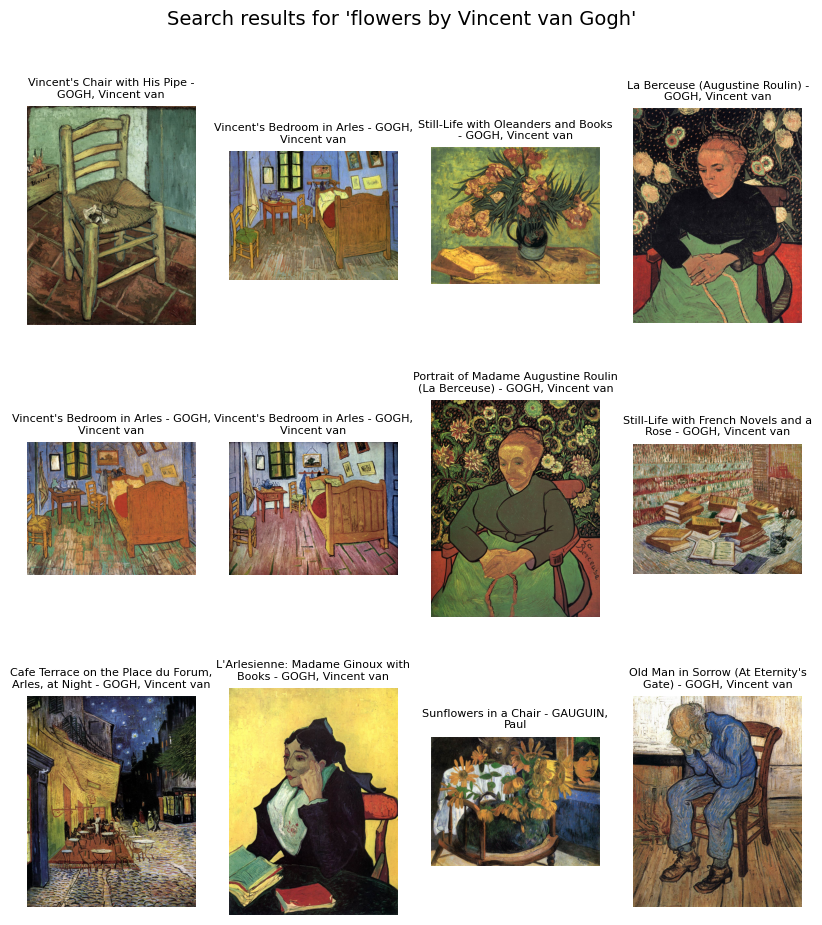

In [33]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]}" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title=f"Search results for '{text_prompt}'",
    nrows=nrows,
    ncols=ncols,
    container_client=blob_container_client,
)

We notice that we were able to retrieve all the paintings obtained with exact search.

In [34]:
cursor.execute(
    f"EXPLAIN ANALYZE "
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} "
    f"WHERE {c.IMAGE_FILE_COLUMN_NAME} != %s "
    f"ORDER BY {c.VECTOR_COLUMN_NAME} <=> (SELECT {c.VECTOR_COLUMN_NAME} FROM {table_name} WHERE {c.IMAGE_FILE_COLUMN_NAME} = %s) "
    f"LIMIT {TOP_N};",
    (image_file, image_file),
)
rows = cursor.fetchall()
print_execution_plan(rows)

Limit  (cost=164.90..167.35 rows=12 width=72) (actual time=1.995..2.131 rows=12 loops=1)
  InitPlan 1 (returns $0)
    ->  Index Scan using paintings_hnsw_pkey on paintings_hnsw paintings_hnsw_1  (cost=0.29..4.30 rows=1 width=18) (actual time=0.018..0.019 rows=1 loops=1)
          Index Cond: (image_file = '17138-arles60.jpg'::text)
  ->  Index Scan using paintings_hnsw_vector_idx on paintings_hnsw  (cost=160.60..2444.69 rows=11205 width=72) (actual time=1.993..2.128 rows=12 loops=1)
        Order By: (vector <=> $0)
        Filter: (image_file <> '17138-arles60.jpg'::text)
        Rows Removed by Filter: 1
Planning Time: 0.290 ms
Execution Time: 2.172 ms


## Close the connection

In [35]:
conn.commit()
cursor.close()
conn.close()